In [44]:
from langgraph.graph import StateGraph, MessagesState, END, START
from typing import TypedDict, List, Dict
from langchain_core.messages import HumanMessage, AIMessage
from IPython.display import Image, display
from langgraph.prebuilt import ToolNode
from openai import OpenAI
import os
from pydantic import BaseModel, model_validator, field_validator
from langgraph.graph import MessagesState  
import json
import asyncio
import aiofiles
from langchain.document_loaders import PyPDFLoader
from langchain_core.messages import BaseMessage
from pydantic import BaseModel, Field, field_validator
from typing import Optional
import easyocr


In [45]:
from dotenv import load_dotenv
import os

# Use the current working directory as the base directory
base_dir = os.getcwd()

# If your .env is one level up from the current directory, use this:
dotenv_path = os.path.join(base_dir, '../.env')

# Load environment variables from the .env file
load_dotenv(dotenv_path)

# Get the API key from the environment variables
api_key = os.getenv('OPENAI_API_KEY')

if api_key is None:
    raise ValueError("Environment variable 'OPENAI_API_KEY' is not set. Please check your .env file.")
else:
    print(f"API Key: {api_key[:5]}...{api_key[-5:]}")

client = OpenAI(api_key=api_key)

API Key: sk-79...zHtMA


In [46]:
try:
    models = client.models.list()
    print(f"Available models: {[model.id for model in models.data[:5]]}")
except Exception as e:
    print(f"Error: {str(e)}")

Available models: ['gpt-4o-realtime-preview-2024-10-01', 'gpt-4o', 'chatgpt-4o-latest', 'dall-e-2', 'gpt-4o-2024-08-06']


In [47]:
# System prompt for consistency across nodes
system_prompt = (
    "You are an AI legal assistant specializing in contract creation and personal information extraction. "
    "Your role is to ensure all responses are formatted clearly, focusing on accuracy, privacy, and legality. "
    "Always ask clarifying questions if any information is incomplete or unclear. Respond concisely and use formal language appropriate for legal contexts."
    "Include all relevant details explicitly and structure output for easy readability."
)


In [48]:
class PIIDataModel(BaseModel):
    name: str = Field(..., description="Full name of the person")
    address: str = Field(..., description="Residential address of the person")

    @model_validator(mode='before')
    def validate_non_empty(cls, values):
        for field in ['name', 'address']:
            if not values.get(field, "").strip():
                raise ValueError(f"Field '{field}' cannot be empty")
        return values

# Define Contract State Model
class ContractState(BaseModel):
    messages: List[str] = Field(default_factory=list)
    extracted_texts: Dict[str, str] = Field(default_factory=dict)
    pii_data: Optional[PIIDataModel] = None
    address: Optional[str] = None
    extracted_text: Optional[str] = None
    buyer: Optional[str] = None
    seller: Optional[str] = None
    contract: Optional[str] = None

# Define Contract Parties Model
class ContractPartiesModel(BaseModel):
    buyer: str = Field(..., description="Full name of the buyer")
    seller: str = Field(..., description="Full name of the seller")

    @model_validator(mode='before')
    def validate_names(cls, values):
        for field in ['buyer', 'seller']:
            value = values.get(field)
            if value and not value.replace(' ', '').isalpha():
                raise ValueError(f"Field '{field}' must contain only alphabetic characters and spaces")
        return values

In [49]:
DATA_FOLDER = 'data'
reader = easyocr.Reader(['en', 'ro'])  

def get_documents() -> List[str]:
    os.makedirs(DATA_FOLDER, exist_ok=True)
    all_files = os.listdir(DATA_FOLDER)
    documents = [
        os.path.join(DATA_FOLDER, f)
        for f in all_files
        if f.lower().endswith(('.pdf', '.jpg', '.jpeg', '.png', '.txt'))
    ]
    print(f"Total files in {DATA_FOLDER}: {len(all_files)}")
    if all_files:
        print(f"Files found: {all_files}")
        print(f"Documents to process: {len(documents)}")
        if not documents:
            print("Warning: No files with supported extensions (.pdf, .jpg, .jpeg, .png, .txt) found.")
    else:
        print(f"The {DATA_FOLDER} folder is empty.")
    return documents

In [50]:
async def extract_text(file_path: str) -> str:
    """
    Extracts text from PDF, JPG, or text files asynchronously.
    
    Args:
        file_path (str): Path to the file to extract text from.
    
    Returns:
        str: Extracted text from the file.
    """
    if file_path.lower().endswith('.pdf'):
        try:
            from langchain.document_loaders import PyPDFLoader
            loader = PyPDFLoader(file_path)
            pages = await asyncio.to_thread(loader.load)
            return "\n".join(page.page_content for page in pages)
        except ImportError:
            return "Error: PyPDFLoader not available. Please install langchain."
    elif file_path.lower().endswith(('.jpg', '.jpeg', '.png')):
        try:
            def process_image():
                results = reader.readtext(file_path)
                return ' '.join([result[1] for result in results])
            return await asyncio.to_thread(process_image)
        except Exception as e:
            return f"Error processing image: {str(e)}"
    else:
        try:
            async with aiofiles.open(file_path, mode='r') as f:
                return await f.read()
        except Exception as e:
            return f"Error reading file: {str(e)}"

async def process_documents() -> Dict[str, str]:
    documents = get_documents()
    results = {}
    for doc in documents:
        try:
            text = await extract_text(doc)
            results[os.path.basename(doc)] = text
        except Exception as e:
            results[os.path.basename(doc)] = f"Error processing file: {str(e)}"
    return results

async def main():
    results = await process_documents()
    for filename, text in results.items():
        print(f"File: {filename}")
        print(f"Extracted text: {text[:500]}...")  # Print first 100 characters
        print("-" * 50)

# For use in Jupyter/IPython environment
import nest_asyncio
nest_asyncio.apply()

# Run the main function
await main()

Total files in data: 2
Files found: ['Screenshot 2024-10-08 at 13.22.38.png', 'Screenshot 2024-10-08 at 13.24.00.png']
Documents to process: 2
File: Screenshot 2024-10-08 at 13.22.38.png
Extracted text: ROUMANIE ROMAWI ROMANIA Caate CARTE De |Dentitate IDENTITY D'iDENTITE seria TR Na 409131 CarD cNP 1891113341181 Nume/Nom/Last name T525M ISPILANTE Prenume/Prenom/First namo SENTIMENT BRUSLI Cetatenle/Nallonallte/Nallonallly Sox SexeiSox Română ROU M Loc nastere/Liou do naissancelPlace ol birth Orș. Videle Jud.Teleorman Dom IlulAdresse/Addrass Videle Jud: Teleorman Sos. Giurgiului nr.1 695 TR Emisa dolDelivree parlIssuad by ValabilltatelValldlte Valldlty SPCLEP Videle 04.11.11-13.11.2018 IDROUISP...
--------------------------------------------------
File: Screenshot 2024-10-08 at 13.24.00.png
Extracted text: ROUMANIE ROVIANIA ROMANIA Carte Carte DE iDentitate idEnTITY D'idEntite Seala SS Nr 099994 Card CNP 2410415400542 93coQ Nume/NomiLast name VASILESCU Pronume/Prenom/Flrst name ELENA <

In [51]:
async def extract_pii_and_address(state: ContractState) -> ContractState:
    extracted_texts = await process_documents()
    print(f"Documents found: {len(extracted_texts)}")

    if not extracted_texts:
        print("No documents found or processed in the data folder.")
        return state

    state.pii_data = []

    for doc, extracted_text in extracted_texts.items():
        print(f"Processing document: {doc}")
        try:
            if not extracted_text or extracted_text.startswith("Error"):
                print(f"Unable to process text from {doc}: {extracted_text}")
                continue

            pii_response = client.chat.completions.create(
                model="gpt-4",
                messages=[
                    {"role": "system", "content": system_prompt},
                    {"role": "user", "content": extracted_text}
                ],
                functions=[{
                    "name": "extract_pii_data",
                    "description": "Extracts the person's full name and address from the provided text.",
                    "parameters": {
                        "type": "object",
                        "properties": {
                            "name": {"type": "string", "description": "Full name of the person."},
                            "address": {"type": "string", "description": "Residential address of the person."}
                        },
                        "required": ["name", "address"]
                    }
                }],
                function_call={"name": "extract_pii_data"}
            )

            function_call = pii_response.choices[0].message.function_call
            if function_call and function_call.arguments:
                pii_data = json.loads(function_call.arguments)
                state.pii_data.append({"document": doc, "data": pii_data})
                print(f"Extracted PII from {doc}: {pii_data}")
            else:
                print(f"No PII data extracted from {doc}")

        except json.JSONDecodeError as e:
            print(f"Error decoding JSON response for {doc}: {str(e)}")
        except Exception as e:
            print(f"Unexpected error processing {doc}: {str(e)}")

    if not state.pii_data:
        print("Failed to extract PII from any document.")

    return state

async def test_extract_pii_and_address():
    state = ContractState(messages=[], extracted_texts={})
    state = await extract_pii_and_address(state)

    if state.pii_data:
        print("\nExtracted PII Data:")
        for item in state.pii_data:
            print(f"\nDocument: {item['document']}")
            print(json.dumps(item['data'], indent=2))
    else:
        print("\nNo PII data extracted.")

    print(f"\nProcessed {len(state.extracted_texts)} documents.")

# Run the test function
await test_extract_pii_and_address()


Total files in data: 2
Files found: ['Screenshot 2024-10-08 at 13.22.38.png', 'Screenshot 2024-10-08 at 13.24.00.png']
Documents to process: 2
Documents found: 2
Processing document: Screenshot 2024-10-08 at 13.22.38.png
Extracted PII from Screenshot 2024-10-08 at 13.22.38.png: {'name': 'ISPILANTE SENTIMENT BRUSLI', 'address': 'Sos. Giurgiului nr.1, Orș. Videle, Jud.Teleorman'}
Processing document: Screenshot 2024-10-08 at 13.24.00.png
Extracted PII from Screenshot 2024-10-08 at 13.24.00.png: {'name': 'ELENA VASILESCU', 'address': 'Mun. Bucuresti Sec. 5 Str Nicolae Iorga nr.3'}

Extracted PII Data:

Document: Screenshot 2024-10-08 at 13.22.38.png
{
  "name": "ISPILANTE SENTIMENT BRUSLI",
  "address": "Sos. Giurgiului nr.1, Or\u0219. Videle, Jud.Teleorman"
}

Document: Screenshot 2024-10-08 at 13.24.00.png
{
  "name": "ELENA VASILESCU",
  "address": "Mun. Bucuresti Sec. 5 Str Nicolae Iorga nr.3"
}

Processed 0 documents.


In [52]:
import asyncio

async def run_extract_pii():
    state = ContractState(messages=[], extracted_texts={})
    updated_state = await extract_pii_and_address(state)

    for message in updated_state.messages:
        print(message.content)

asyncio.run(run_extract_pii())


Total files in data: 2
Files found: ['Screenshot 2024-10-08 at 13.22.38.png', 'Screenshot 2024-10-08 at 13.24.00.png']
Documents to process: 2
Documents found: 2
Processing document: Screenshot 2024-10-08 at 13.22.38.png
Extracted PII from Screenshot 2024-10-08 at 13.22.38.png: {'name': 'ISPILANTE SENTIMENT BRUSLI', 'address': 'Videle Jud: Teleorman Sos. Giurgiului nr.1 695 TR'}
Processing document: Screenshot 2024-10-08 at 13.24.00.png
Extracted PII from Screenshot 2024-10-08 at 13.24.00.png: {'name': 'ELENA VASILESCU', 'address': 'Mun. Bucuresti Sec. 5 Str Nicolae Iorga nr.3 900 B'}


In [53]:
state = ContractState(messages=[], extracted_texts={}, pii_data=None)
updated_state = missing_information(state)

for message in updated_state.messages:
    print(message.content)


Please provide the missing information regarding PII or address.


In [75]:
# Create an empty state to simulate a situation where information is missing
state = ContractState(
    messages=[],
    extracted_texts={},
    pii_data=None,  # No PII data provided
    address=None
)

# Run the missing_information function
updated_state = missing_information(state)

# Print out the messages to verify the expected output
for message in updated_state.messages:
    print(message.content)


No PII data available. Please provide name and address.


In [79]:
import asyncio

async def run_extract_pii():
    state = ContractState(messages=[], extracted_texts={})
    updated_state = await extract_pii_and_address(state)

    for message in updated_state.messages:
        print(message.content)
    
    # Check if pii_data was extracted
    if updated_state.pii_data is not None:
        print("PII data extracted:", updated_state.pii_data)
    else:
        print("No PII data extracted.")

    return updated_state

state = asyncio.run(run_extract_pii())


Total files in data: 2
Files found: ['Screenshot 2024-10-08 at 13.22.38.png', 'Screenshot 2024-10-08 at 13.24.00.png']
Documents to process: 2
Documents found: 2
Processing document: Screenshot 2024-10-08 at 13.22.38.png
Extracted PII from Screenshot 2024-10-08 at 13.22.38.png: {'name': 'ISPILANTE SENTIMENT BRUSLI', 'address': 'Videle Jud: Teleorman Sos. Giurgiului nr.1'}
Processing document: Screenshot 2024-10-08 at 13.24.00.png
Extracted PII from Screenshot 2024-10-08 at 13.24.00.png: {'name': 'ELENA VASILESCU', 'address': 'Mun. Bucuresti Sec. 5 Str Nicolae Iorga nr.3 900 B'}
PII data extracted: [{'document': 'Screenshot 2024-10-08 at 13.22.38.png', 'data': {'name': 'ISPILANTE SENTIMENT BRUSLI', 'address': 'Videle Jud: Teleorman Sos. Giurgiului nr.1'}}, {'document': 'Screenshot 2024-10-08 at 13.24.00.png', 'data': {'name': 'ELENA VASILESCU', 'address': 'Mun. Bucuresti Sec. 5 Str Nicolae Iorga nr.3 900 B'}}]


In [94]:
async def human_verification(state: ContractState) -> ContractState:
    if state.pii_data:
        # Generate a verification question based on the extracted PII data
        verification_prompt = f"Generate a simple yes/no question to verify this information: Name: {state.pii_data[0]['data']['name']}, Address: {state.pii_data[0]['data']['address']}"
        
        question_response = await client.chat.completions.create(
            model="gpt-4",
            messages=[
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": verification_prompt}
            ],
            max_tokens=50
        )
        
        verification_question = question_response.choices[0].message.content.strip()
        
        # Add the verification question to the state messages
        state.messages.append(AIMessage(content=f"Human verification required. {verification_question}"))
        
        # In a real application, you would wait for actual user input here
        # For testing purposes, we'll simulate a human response
        simulated_human_response = "Yes, the information is correct."
        state.messages.append(HumanMessage(content=simulated_human_response))
        
        # Evaluate the response
        evaluation_prompt = f"Question: {verification_question}\nResponse: {simulated_human_response}\n\nDoes this response indicate that the information is correct? Respond with 'VERIFIED' if it does, or 'NOT VERIFIED' if it doesn't."
        
        evaluation_response = await client.chat.completions.create(
            model="gpt-4",
            messages=[
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": evaluation_prompt}
            ],
            max_tokens=10
        )
        
        evaluation = evaluation_response.choices[0].message.content.strip()
        
        if evaluation == "VERIFIED":
            state.messages.append(AIMessage(content="Human verification successful. Proceeding with the process."))
        else:
            state.messages.append(AIMessage(content="Human verification failed. Please check the information and try again."))
            return END
    else:
        state.messages.append(AIMessage(content="No PII data found for verification."))

    return state

In [95]:
async def test_human_verification():
    state = ContractState(messages=[], extracted_texts={})
    state.pii_data = [{"document": "test_doc", "data": {"name": "John Doe", "address": "123 Main St, Anytown, USA"}}]
    updated_state = await human_verification(state)
    
    print("Messages after human verification:")
    for message in updated_state.messages:
        print(f"{message.type}: {message.content}")

# Run the test
await test_human_verification()

Messages after human verification:
ai: Human verification required. Is the provided information correct, confirming that your name is John Doe and your address is 123 Main St, Anytown, USA?
human: Yes, the information is correct.
ai: Human verification successful. Proceeding with the process.


In [10]:
async def extract_pii_and_address(state: ContractState) -> ContractState:
    extracted_texts = await process_documents()
    print(f"Documents found: {len(extracted_texts)}")

    if not extracted_texts:
        state.messages.append(AIMessage(content="No documents found in the data folder."))
        return state

    state.pii_data = []

    for doc, extracted_text in extracted_texts.items():
        print(f"Processing document: {doc}")
        try:
            if not extracted_text or extracted_text.startswith("Error"):
                state.messages.append(AIMessage(content=f"Unable to process text from {doc}: {extracted_text}"))
                continue

            pii_response = client.chat.completions.create(
                model="gpt-4",
                messages=[
                    {"role": "system", "content": system_prompt},
                    {"role": "user", "content": extracted_text}
                ],
                functions=[{
                    "name": "extract_pii_data",
                    "description": "Extracts the person's full name and address from the provided text.",
                    "parameters": {
                        "type": "object",
                        "properties": {
                            "name": {"type": "string", "description": "Full name of the person."},
                            "address": {"type": "string", "description": "Residential address of the person."}
                        },
                        "required": ["name", "address"]
                    }
                }],
                function_call={"name": "extract_pii_data"}
            )

            function_call = pii_response.choices[0].message.function_call
            if function_call and function_call.arguments:
                pii_data = json.loads(function_call.arguments)
                state.pii_data.append({"document": doc, "data": pii_data})
                state.messages.append(AIMessage(content=f"Extracted PII from {doc}: {pii_data}"))
                state.extracted_text = extracted_text
            else:
                state.messages.append(AIMessage(content=f"No PII data extracted from {doc}"))

        except json.JSONDecodeError:
            state.messages.append(AIMessage(content=f"Error decoding JSON response for {doc}"))
        except ValueError as e:
            state.messages.append(AIMessage(content=f"Validation error for {doc}: {str(e)}"))
        except Exception as e:
            state.messages.append(AIMessage(content=f"Unexpected error processing {doc}: {str(e)}"))

    if not state.pii_data:
        state.messages.append(AIMessage(content="Failed to extract PII from any document."))

    return state

def missing_information(state: ContractState) -> ContractState:
    # Append a message to the state indicating missing information
    state.messages.append(AIMessage(content="Please provide the missing information regarding PII or address."))
    return state

def human_verification(state: ContractState) -> ContractState:
    # Ensure pii_data is accessed correctly
    if state.pii_data is not None:
        verification_prompt = f"Is this information correct?\nName: {state.pii_data.name}, Address: {state.address}"
        
        # Create a completion using OpenAI's ChatCompletion
        response = openai.ChatCompletion.create(
            model="gpt-4",
            messages=[
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": verification_prompt}
            ],
            max_tokens=50,
            temperature=0.7
        )
        
        # Append the response content to the state messages
        state.messages.append(AIMessage(content=response.choices[0].message["content"].strip()))
    else:
        state.messages.append(AIMessage(content="No PII data found for verification."))

    return state


def identify_buyer_and_seller(state: ContractState) -> ContractState:
    # Using function calling to extract buyer and seller details
    functions = [
        {
            "name": "identify_parties",
            "description": "Identifies the buyer and seller from the given text.",
            "parameters": {
                "type": "object",
                "properties": {
                    "buyer": {"type": "string", "description": "Name of the buyer."},
                    "seller": {"type": "string", "description": "Name of the seller."}
                },
                "required": ["buyer", "seller"]
            }
        }
    ]

    response = client.ChatCompletion.create(
        model="chatgpt-4",
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": "Identify the buyer and seller from the context."}
        ],
        functions=functions,
        function_call="auto"
    )
    parties = json.loads(response.choices[0].message["function_call"]["arguments"])
    # Validate using Pydantic
    parties_model = ContractPartiesModel(**parties)
    state.buyer = parties_model.buyer
    state.seller = parties_model.seller
    return state

def construct_contract(state: ContractState) -> ContractState:
    # Using function calling to generate the contract
    functions = [
        {
            "name": "generate_contract",
            "description": "Generates a contract between buyer and seller for the given address.",
            "parameters": {
                "type": "object",
                "properties": {
                    "buyer": {"type": "string", "description": "Name of the buyer."},
                    "seller": {"type": "string", "description": "Name of the seller."},
                    "address": {"type": "string", "description": "Address where the contract is applicable."}
                },
                "required": ["buyer", "seller", "address"]
            }
        }
    ]

    response = client.ChatCompletion.create(
        model="gpt-4",
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": "Create a contract between buyer and seller using the provided information."}
        ],
        functions=functions,
        function_call="auto"
    )

    try:
        # Extract the function call arguments
        contract_data = json.loads(response.choices[0].message["function_call"]["arguments"])
        
        # Validate using Pydantic
        parties_model = ContractPartiesModel(**contract_data)
        state.buyer = parties_model.buyer
        state.seller = parties_model.seller
        state.address = contract_data['address']
        
        # Create contract string (example format)
        state.contract = (
            f"This contract is made between {state.buyer} (Buyer) and {state.seller} (Seller), "
            f"with the following terms to apply at {state.address}."
        )

        state.messages.append(AIMessage(content=f"Contract created: {state.contract}"))

    except json.JSONDecodeError:
        state.messages.append(AIMessage(content="Error decoding JSON response while constructing the contract."))
    except ValueError as e:
        state.messages.append(AIMessage(content=f"Validation error while constructing the contract: {str(e)}"))
    except Exception as e:
        state.messages.append(AIMessage(content=f"Unexpected error while constructing the contract: {str(e)}"))

    return state


In [96]:
async def identify_buyer_and_seller(state: ContractState) -> ContractState:
    functions = [
        {
            "name": "identify_parties",
            "description": "Identifies the buyer and seller from the given text.",
            "parameters": {
                "type": "object",
                "properties": {
                    "buyer": {"type": "string", "description": "Name of the buyer."},
                    "seller": {"type": "string", "description": "Name of the seller."}
                },
                "required": ["buyer", "seller"]
            }
        }
    ]

    response = await client.chat.completions.create(
        model="gpt-4",
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": "Identify the buyer and seller from the context."}
        ],
        functions=functions,
        function_call="auto"
    )
    parties = json.loads(response.choices[0].function_call.arguments)
    # Validate using Pydantic
    parties_model = ContractPartiesModel(**parties)
    state.buyer = parties_model.buyer
    state.seller = parties_model.seller
    return state


async def construct_contract(state: ContractState) -> ContractState:
    functions = [
        {
            "name": "generate_contract",
            "description": "Generates a contract between buyer and seller for the given address.",
            "parameters": {
                "type": "object",
                "properties": {
                    "buyer": {"type": "string", "description": "Name of the buyer."},
                    "seller": {"type": "string", "description": "Name of the seller."},
                    "address": {"type": "string", "description": "Address where the contract is applicable."}
                },
                "required": ["buyer", "seller", "address"]
            }
        }
    ]

    response = await client.chat.completions.create(
        model="gpt-4",
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": "Create a contract between buyer and seller using the provided information."}
        ],
        functions=functions,
        function_call="auto"
    )

    try:
        contract_data = json.loads(response.choices[0].function_call.arguments)
        
        parties_model = ContractPartiesModel(**contract_data)
        state.buyer = parties_model.buyer
        state.seller = parties_model.seller
        state.address = contract_data['address']
        
        state.contract = (
            f"This contract is made between {state.buyer} (Buyer) and {state.seller} (Seller), "
            f"with the following terms to apply at {state.address}."
        )

        state.messages.append(AIMessage(content=f"Contract created: {state.contract}"))

    except json.JSONDecodeError:
        state.messages.append(AIMessage(content="Error decoding JSON response while constructing the contract."))
    except ValueError as e:
        state.messages.append(AIMessage(content=f"Validation error while constructing the contract: {str(e)}"))
    except Exception as e:
        state.messages.append(AIMessage(content=f"Unexpected error while constructing the contract: {str(e)}"))

    return state

In [ ]:
client = AsyncOpenAI(api_key=api_key)

In [97]:

graph = StateGraph(ContractState)

graph.add_node("extract_pii_and_address", extract_pii_and_address)
graph.add_node("human_verification", human_verification)
graph.add_node("missing_information", missing_information)
graph.add_node("identify_buyer_and_seller", identify_buyer_and_seller)
graph.add_node("construct_contract", construct_contract)

# Define edges (example)
graph.set_entry_point("extract_pii_and_address")
graph.add_edge("extract_pii_and_address", "human_verification")
graph.add_conditional_edges(
    "human_verification",
    lambda state: "missing_information" if not state.pii_data else "identify_buyer_and_seller"
)
graph.add_edge("missing_information", "extract_pii_and_address")
graph.add_edge("identify_buyer_and_seller", "construct_contract")
graph.add_edge("construct_contract", END)

# Compile the graph
app = graph.compile()

In [43]:
# # Create the graph
# graph = StateGraph(ContractState)

# # Add nodes
# graph.add_node("extract_text", extract_text)
# graph.add_node("extract_pii_and_address", extract_pii_and_address)
# graph.add_node("human_verification", human_verification)
# graph.add_node("missing_information", missing_information)
# graph.add_node("identify_buyer_and_seller", identify_buyer_and_seller)
# graph.add_node("construct_contract", construct_contract)

# # Define edges
# graph.set_entry_point("extract_text")
# graph.add_edge("extract_text", "extract_pii_and_address")
# graph.add_edge("extract_pii_and_address", "human_verification")
# graph.add_conditional_edges("human_verification", lambda state: "missing_information" if "missing" in state else "identify_buyer_and_seller")
# graph.add_edge("missing_information", "human_verification")
# graph.add_edge("identify_buyer_and_seller", "construct_contract")
# graph.add_edge("construct_contract", END)

# # Compile the graph
# app = graph.compile()
# # Example invocation
# initial_state = ContractState()
# result = await app.ainvoke(initial_state)
# print(result)





In [100]:
# async def run_graph():
#     initial_state = ContractState(messages=[], extracted_texts={})
#     result = await app.ainvoke(initial_state)
#     return result

# # Run the graph
# result = asyncio.run(run_graph())

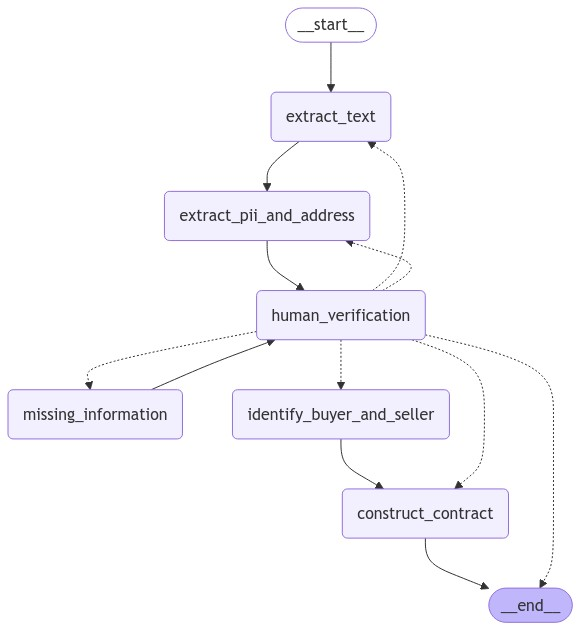

In [24]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass